In [89]:
from __future__ import print_function
import os
import inspect

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context('talk') #, font_scale=1.0, rc={"lines.linewidth": 1.0})
sns.set_palette('dark')
#sns.set_style("whitegrid",{'axes.edgecolor':'black'})

%matplotlib inline

In [103]:
# Import pdNLS

try:
    # If pdNLS is in PYTHONPATH (or is installed), then use a direct import
    import pdNLS
    
except ImportError:
    # Attempt to demo pdNLS without installing by importing from directory
    pdNLS_path = '../../pdNLS'
    
    print("Module pdNLS was not found in PYTHONPATH. Looking for module in directory '{:s}'".format(pdNLS_path))
    
    if os.path.exists(pdNLS_path):
        import imp
        pdlmfit = imp.load_package('pdNLS', pdNLS_path)
        print("Module pdNLS was found in the directory '{:s}' and imported.".format(pdNLS_path))
    else:
        raise ImportError("Module pdNLS could not be found in the directory '{:s}'.".format(pdNLS_path) + \
        "This demonstration will not run until the module is located.")

Module pdNLS was not found in PYTHONPATH. Looking for module in directory '../../pdNLS'


ImportError: Module pdNLS could not be found in the directory '../../pdNLS'.This demonstration will not run until the module is located.

## Overview

`pdNLS` is a library for performing non-linear least squares (NLS) minimization. It attempts to seamlessly incorporate this task in a Pandas-focused workflow. Input data are expected in dataframe format, and multiple regressions can be performed using functionality similar to Pandas `groupby`. Results are returned as grouped dataframes and include best-fit parameters, statistics, residuals, and more. The results can be easily visualized using [`seaborn`](https://github.com/mwaskom/seaborn).

`pdNLS` is related to libraries such as [`statsmodels`](http://statsmodels.sourceforge.net) and [`scikit-learn`](http://scikit-learn.org/stable/) that provide linear regression functions that operate on dataframes. However, I was unable to find any that perform non-linear regression. I developed `pdNLS` to fill this niche. 

`pdNLS` utilizes [`lmfit`](https://github.com/lmfit/lmfit-py), a flexible and powerful library for non-linear least squares minimization, which in turn, makes use of `scipy.optimize.leastsq`. I began using `lmfit` several years ago because I like the flexibility it offers for testing different modeling scenarios and the variety of assessment statistics it provides. However, I found myself writing many `for` loops to perform regressions on groups of data and aggregate the resulting output.

Some additional 'niceties' associated with the input of parameters and equations have also been incorporated. `pdNLS` also utilizes multithreading for the calculation of confidence intervals, as this process is time consuming when there are more than a few groups.

## Setup

### Dependencies

* numpy
* pandas


My stuff  
* lmfit
* multiprocess  
can install using conda or pip

plotting
* matplotlib
* seaborn

### Demo

on binder, with notebooks

### Data

Following is a demonstration of pdlmfit using nuclear magnetic resonance (NMR) data that I acquired at four different magnetic field strengths (14.1, 16.5, 18.8, and 21.1 T) on a protein called GCN4. There are data at each field strength for 54 amino acids, making a total of 216 regressions that are performed by pdlmfit.

In [6]:
data_file = 'GCN4_fourfield_R2.tsv'
! head {data_file}

resi	field	time	intensity
5	14.1	0.004	15615.70107
5	14.1	0.008	15647.389419
5	14.1	0.024	13730.034692
5	14.1	0.064	11014.702949
5	14.1	0.096	9902.33449
5	14.1	0.144	8015.479907
5	14.1	0.208	6081.721596
5	14.1	0.008	13954.001156
5	14.1	0.024	12811.896502


In [7]:
data = pd.read_csv(data_file, sep='\t')
#data = data.loc[(data.resi<=10)&(data.field<17.0)].reset_index(drop=True)

### Equation

Unpacking parameters--link to lmfit documentation

Some equations are provided.

The parameters of an exponential decay function will be fit to the data:  

$I_{(t)} = I_{(0)} \space e^{(-R_2 * t)}$  

where $I_{(0)}$ is the initial intensity, $I_{(t)}$ is the intensity at time $t$, and $R_2$ is the transverse relaxation rate. 

The regression requires the data, a list of columns to group the data by (`resi` and `field`), the names of the dataframe columns containing the independent and dependent variables (`time` and `intensity`, respectively), and the name of the function (`exp`).

In [102]:
print(inspect.getsource(exponential_decay))

def exponential_decay(par, xdata):
    
    # Parse multiple input parameter
    # formats for intensity, rate    
    if hasattr(par,'valuesdict'):
        # lmfit parameter format
        var = par.valuesdict()
        inten = var['inten']
        rate = var['rate']
    elif hasattr(par,'keys'):
        # dict format
        inten = par['inten']
        rate = par['rate']
    else:
        # array/list/tuple format
        inten = par[0]
        rate = par[1]

    # Calculate the y-data from the parameters
    return inten * np.exp(-1*rate*xdata)



In [8]:
def exponential_decay(par, xdata):
    
    # Parse multiple input parameter
    # formats for intensity, rate    
    if hasattr(par,'valuesdict'):
        # lmfit parameter format
        var = par.valuesdict()
        inten = var['inten']
        rate = var['rate']
    elif hasattr(par,'keys'):
        # dict format
        inten = par['inten']
        rate = par['rate']
    else:
        # array/list/tuple format
        inten = par[0]
        rate = par[1]

    # Calculate the y-data from the parameters
    return inten * np.exp(-1*rate*xdata)

### Column names

group by columns, xname, yname, error

In [9]:
groupcols = ['resi', 'field']
xname = 'time'
yname = 'intensity'
yerr = None

### Parameters

parameters are a dictionary or a dataframe, can be a single value or list of identical length--ensure order is the same as they are unpacked in the equation.

How to handle constants

Explain what I've done here.

In [10]:
params = [{'name':'inten', 'value':np.asarray(data.groupby(groupcols)[yname].max()), 'vary':True},
          {'name':'rate', 'value':20.0, 'vary':True}]

### Confidence interval(s)

can be single or list, default is 0.95

In [11]:
sigma = 0.95

### Regression method

Only `leastsq` is supported right now.

In [12]:
method = 'leastsq'

### Other parameters

`threads`

## Regression

In [27]:
fit_data = pdlmfit.pdlmfit(data, exponential_decay, 
                           groupcols, params, 
                           xname, yname, 
                           method=method, sigma=sigma)
fit_data.fit()

## Results

In [28]:
fit_data.data.sortlevel(axis=0).loc[(10, 14.1)].head(n=8)

time     intensity
resi field                     
10   14.1   0.004  10434.829430
     14.1   0.008   9929.584417
     14.1   0.024   8557.808615
     14.1   0.064   6414.364701
     14.1   0.096   5253.764094
     14.1   0.144   4019.250506
     14.1   0.208   2689.306701
     14.1   0.008   9109.241833

In [29]:
fit_data.results.head(n=8)

inten                                rate            \
                    value       stderr       ci0.95     value    stderr   
resi field                                                                
5    14.1    15313.367271   139.475597   232.504669  5.085937  0.153085   
     16.5    68692.303692   362.676887   618.930303  5.510422  0.132718   
     18.8   318852.491958   940.572232  1593.726552  6.988834  0.096050   
     21.1   831932.375915  1428.215703  2543.892832  5.950005  0.032391   
6    14.1    12150.037320   125.957061   210.737126  5.913539  0.227691   
     16.5    67337.150278   336.018198   572.242574  5.697662  0.130639   
     18.8   257864.943838   555.307822   905.503586  6.247189  0.041395   
     21.1   768077.405112  1923.626547  2928.719491  6.318552  0.036332   

                      
              ci0.95  
resi field            
5    14.1   0.266440  
     16.5   0.222188  
     18.8   0.180865  
     21.1   0.059709  
6    14.1   0.403435  
     16.5   0.239861  
     18.8   0.075436  
     21.1   0.063240

In [30]:
fit_data.results.loc[10]

inten                               rate                    
               value      stderr       ci0.95     value    stderr    ci0.95
field                                                                      
14.1    10138.093669   81.913608   136.751085  7.178645  0.204430  0.361709
16.5    50868.876634  212.575306   366.034028  6.945686  0.127468  0.200281
18.8   190379.105476  691.417195  1177.565529  8.571641  0.172095  0.283685
21.1   560960.283077  784.645950  1305.888739  8.104072  0.041178  0.081481

In [31]:
fit_data.results.loc[(10, 18.8)]

inten  value     190379.105476
       stderr       691.417195
       ci0.95      1177.565529
rate   value          8.571641
       stderr         0.172095
       ci0.95         0.283685
Name: (10, 18.8), dtype: float64

In [32]:
fit_data.stats.loc[(slice(None), 18.8), :].head(n=10)

,,nobs,npar,dof,chisqr,redchi,aic,bic,covar
resi,field,,,,,,,,
5,18.8,22,2,20,1.438859e+16,7.194297e+14,756.608557,758.790642,"[[884676.124346, 45.5837120289], [45.583712028..."
6,18.8,22,2,20,9.511367e+14,4.755683e+13,696.844825,699.026910,"[[308366.776811, 14.1178723296], [14.117872329..."
7,18.8,22,2,20,6.757987e+15,3.378993e+14,739.982921,742.165006,"[[608954.405556, 36.0892684742], [36.089268474..."
8,18.8,22,2,20,1.309060e+16,6.545302e+14,754.528656,756.710741,"[[1168137.54813, 68.1092848262], [68.109284826..."
9,18.8,22,2,20,8.003952e+15,4.001976e+14,743.705551,745.887635,"[[856305.140309, 59.5849096275], [59.584909627..."
10,18.8,22,2,20,3.991318e+15,1.995659e+14,728.397645,730.579730,"[[478057.738111, 62.0956604465], [62.095660446..."
11,18.8,22,2,20,7.894043e+14,3.947022e+13,692.744484,694.926569,"[[341740.934542, 27.8389841278], [27.838984127..."
12,18.8,22,2,20,8.292703e+14,4.146352e+13,693.828371,696.010456,"[[364853.83623, 32.9641394096], [32.9641394096..."
13,18.8,22,2,20,1.156430e+15,5.782149e+13,701.144396,703.326481,"[[449485.765327, 74.8523210929], [74.852321092..."


In [34]:
fit_data.stats.covar.loc[(slice(None), 18.8)].head(10)

resi
5     [[884676.124346, 45.5837120289], [45.583712028...
6     [[308366.776811, 14.1178723296], [14.117872329...
7     [[608954.405556, 36.0892684742], [36.089268474...
8     [[1168137.54813, 68.1092848262], [68.109284826...
9     [[856305.140309, 59.5849096275], [59.584909627...
10    [[478057.738111, 62.0956604465], [62.095660446...
11    [[341740.934542, 27.8389841278], [27.838984127...
12    [[364853.83623, 32.9641394096], [32.9641394096...
13    [[449485.765327, 74.8523210929], [74.852321092...
14    [[114793.151904, 29.1087000161], [29.108700016...
Name: covar, dtype: object

## Predictions

In [20]:
# fit_data.predict()
# fit_data.model.head()

## Visualization

In [83]:
fit_itensities = (fit_data.results
                  .loc[:,('inten','value')]
                  .to_frame()
                  )
fit_itensities.columns=['inten_fit']

In [86]:
fit_data.data = pd.merge(fit_data.data,
                         fit_itensities,
                         left_index=True,
                         right_index=True,
                         how='left'
                        )

fit_data.data['intensity'] /= fit_data.data.inten_fit
#fit_data.data['ycalc'] /= fit_data.data.inten_fit

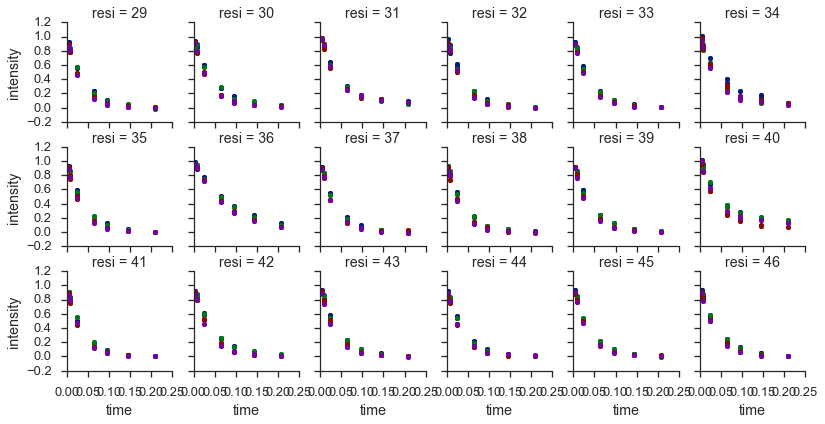

In [91]:
# sns.set_context("notebook", font_scale=1.0, rc={"lines.linewidth": 1.0})
# sns.set_style("whitegrid",{'axes.edgecolor':'black'})

plot_data = fit_data.data.reset_index()
plot_data = plot_data.loc[(plot_data.resi>=29)&((plot_data.resi<=46))]

# colors = sns.color_palette()
# palette = {14.1:colors[0], 16.5:colors[1], 18.8:colors[2], 21.1:colors[3]}

grid = sns.FacetGrid(plot_data, col='resi', hue='field', #palette=palette,
                     col_wrap=6, size=2.0, aspect=0.75, sharey=True, despine=True)

# grid.map(plt.plot, 'time', 'ycalc', marker='', ls='-')
grid.map(plt.plot, 'time', 'intensity', marker='o', ms=5, ls='')

f = plt.gcf()
f.set_size_inches(12,6)
f.subplots_adjust(wspace=0.2, hspace=0.25)

In [34]:
def predict(self, df, xcalc=False, xtype='global', xnum=50):
    
    # Get the index for selection
    index = df.index.unique()[0]
    
    # Choose the xdata
    xname = self._xname
    xdata = self.data.loc[index, xname]
    
    if xcalc:
        if xtype == 'global':
            xmin = self.data[xname].min()
            xmax = self.data[xname].max()
        else:
            xmin = xdata.min()
            xmax = xdata.max()
            
        xname = 'xdata'
        xdata = pd.Series(np.linspace(xmin, xmax, xnum))
        xindex = pd.Index(np.array([index]*xnum))
    
    # Pick out the parameters for this data
    params = ( self
             .results
             .sortlevel(axis=1)
             .loc[[index], (slice(None),['value'])]
             )
    params.columns = params.columns.levels[0]
    params = params[self._paramnames].squeeze()
    
    
    model_eq = self._fitobj.model_eq.loc[index]
    
    ycalc = model_eq(params, xdata)
    
    if not xcalc:
        return ycalc
    else:
        return pd.DataFrame({xname:xdata, 'ycalc':ycalc})




z = ( a
     .data
     .groupby(level=range(a._ngroupcols), group_keys=False, as_index=False)
     .apply(lambda x: predict(a, x, True, xnum=5))
     )
z

,xdata,ycalc
0,0.004,15004.983475
1,0.055,11576.759543
2,0.106,8931.790011
3,0.157,6891.122901
4,0.208,5316.691814
0,0.004,67194.774141
1,0.055,50732.360278
2,0.106,38303.162892
3,0.157,28919.062301
4,0.208,21834.023647
